In [52]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [53]:
def ecdf(data):
    plt.plot(np.sort(data), np.linspace(0,1,len(data)))

## Data Loading

In [59]:
train_o = pd.read_csv("data/train.csv")
test_o = pd.read_csv("data/test.csv")

In [60]:
def fillize(data):
    """Replace NaNs with zero, and adds indicator
    *only checks opened_position_qty"""
    nans = np.isnan(data["opened_position_qty "])
    return data.fillna(0).assign(nans=nans)

def deidize(data):
    """drop id column"""
    return data.drop("id", axis=1)

def relize(data):
    """replace bid[i] and ask[i] columns with
    bid[i]-bid[i-1] ans ask[i]-ask[i-1]"""
    rel = data.copy()
    for i in range(5,1,-1):
        rel[f"bid{i}"] = rel[f"bid{i-1}"] - rel[f"bid{i}"]
        rel[f"ask{i}"] -= rel[f"ask{i-1}"]

    rel["bid1"] = rel["last_price"] - rel["bid1"]
    rel["ask1"] -= rel["last_price"]
    return rel

import sklearn.preprocessing
def normall(datas):
    """standardize last_price, mid, and d_open_interest"""
    scaler_price = sklearn.preprocessing.StandardScaler()
    scaler_price.fit(datas[0][["last_price"]])
    scaler_interest = sklearn.preprocessing.StandardScaler()
    scaler_interest.fit(datas[0][["d_open_interest"]])

    normeds = []
    for data in datas:
        normed = data.copy()
        normed[["last_price","mid"]] = scaler_price.transform(normed[["last_price","mid"]])
        normed[["d_open_interest"]] = scaler_interest.transform(normed[["d_open_interest"]])
        normeds.append(normed)
    return normeds

def logize(data):
    cols = sum([
        ["opened_position_qty ", "closed_position_qty", "transacted_qty"],
        [f"bid{i}" for i in range(2,6)],
        [f"bid{i}vol" for i in range(1,6)],
        [f"ask{i}" for i in range(2,6)],
        [f"ask{i}vol" for i in range(1,6)],
    ], [])
    logged = data.copy()
    logged.loc[:,cols] = np.log1p(logged.loc[:,cols])
    return logged

import sklearn.model_selection
def splitize(data):
    """make train and validation set"""
    return sklearn.model_selection.train_test_split(data.drop("y",axis=1), data["y"])

In [61]:
prepr = lambda data:logize(fillize(relize(deidize(data))))

ftrainX, ftrainY = prepr(train_o.drop("y",axis=1)), train_o["y"]
ftrainX, ftestX = normall([ftrainX, prepr(test_o)])

trainX, valX, trainY, valY = splitize(train_o)
trainX, valX, testX = normall([prepr(trainX), prepr(valX), prepr(test_o)])

In [62]:
class StockDataset(Dataset):
    def __init__(self, x, y):
        self.X = torch.tensor(x.values.astype(np.float32), dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):       
        return (self.X[idx],
                self.y[idx]
               )

In [63]:
bsize = 32

train = DataLoader(StockDataset(trainX, trainY), batch_size=bsize, shuffle=True)
val = DataLoader(StockDataset(valX, valY), batch_size=bsize, shuffle=True)
ftrain = DataLoader(StockDataset(ftrainX, ftrainY), batch_size=bsize)

## Train

In [64]:
def mfit(model, train, val, lr=1e-3, nepochs=10):
    model.cuda()
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    s_train = np.zeros(nepochs)
    s_val = np.zeros(nepochs)
    for epoch in range(nepochs):
        model.train()
        for i, (data, target) in enumerate(train):
            data, target = data.cuda(), target.cuda()
            if (i % int(len(train)/20) == 0):
                print(f"{int(i/len(train)*20)} ", end="")
            optimizer.zero_grad()
            output = model(data)
            loss = loss_fn(output, target)
            loss.backward()
            optimizer.step()

        s_val[epoch] = meval(model, val)
        s_train[epoch] = meval(model, train)
        print(s_train[epoch], s_val[epoch])
    return s_train, s_val

def meval(model, data, nsamp=8):
    model.eval()
    bsize = data.batch_size
    outs = torch.zeros(nsamp*bsize)
    targets = torch.zeros(nsamp*bsize)
    sm = nn.Softmax(dim=1)
    for i, (data, target) in enumerate(data):
        if (i >= nsamp):
            break
        outs[i*bsize:(i+1)*bsize] = sm(model(data).detach())[:,1]
        targets[i*bsize:(i+1)*bsize] = target
    return sklearn.metrics.roc_auc_score(targets, outs)

In [71]:
model = torch.nn.Sequential(
    nn.Linear(27, 10),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(10, 5),
    nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(5,2)
)

In [72]:
strain, sval = mfit(model, train, val, nepochs=5, lr=1e-4)

0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.6121089607635206 0.5584856035437431
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.6376518218623481 0.6443738977072311
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.6757047702348112 0.6983969918860083
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.6267587369513065 0.646484375
0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 0.7082921037007718 0.6781121751025992


## Predict

In [67]:
test = torch.tensor(testX.values.astype(np.float32))

In [68]:
sm = nn.Softmax(dim=1)
p = sm(model(test).detach())[:,1]

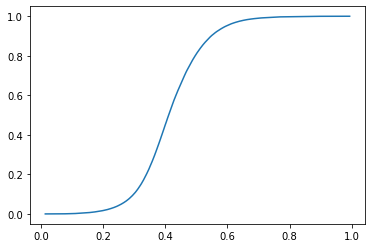

In [69]:
ecdf(p)

In [70]:
out = pd.DataFrame({"id":test_o.iloc[:,0], "Predicted":p})

with open("net.csv", "w") as f:
    f.write(out.to_csv(index=False))